In [176]:
%pylab inline
import pandas as pd
import plotnine as p
p.theme_set(p.theme_classic())

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
counts = pd.read_parquet('mca_brain_counts.parquet')

In [4]:
sample_info = pd.read_parquet('mca_brain_cell_info.parquet')

### Differential expression

Now let us investigate how this count depth effect plays in to a differential expression analysis. With all published large scale experiments cataloging cell types, it is getting increasingly easy to simply fetch some data and do quick comparisons. We will use data from the recent [single cell Mouse Cell Atlas](http://www.cell.com/cell/abstract/S0092-8674(18)30116-8). To get something easy to compare, we use the samples called "Brain" and focus on the cells annotated as "Microglia" and "Astrocyte". Out of the ~400,000 cells in the study, these two cell types have 338 and 199 representative cells. On average they have about 700 total UMI counts each, so while the entire study is a pretty large scale, the individual cell types and cells are on a relatively small scale. The final table has 537 cells and 21,979 genes.

In [6]:
sample_info['super_cell_type'].value_counts()

Myelinating oligodendrocyte       3150
Microglia                          338
Astrocyte                          199
Macrophage                         124
Oligodendrocyte precursor cell      72
Neuron                              48
Astroglial cell(Bergman glia)       30
Pan-GABAergic                       26
Granulocyte                         26
Schwann cell                        16
Hypothalamic ependymal cell          9
Name: super_cell_type, dtype: int64

In [9]:
sub_samples = sample_info.query('super_cell_type in ["Microglia", "Astrocyte"]').copy()

In [11]:
sub_counts = counts.reindex(index=sub_samples.index)

In [182]:
sub_counts.shape

(537, 21979)

In [14]:
sub_samples['is_astrocyte'] = sub_samples['super_cell_type'] == 'Astrocyte'

In [16]:
import NaiveDE

In [21]:
sub_samples['total_count'] = sub_counts.sum(1)

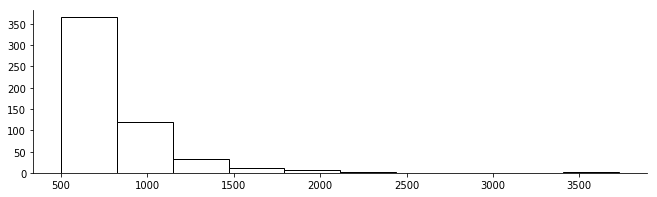

In [175]:
figsize(11, 3)
sub_samples.total_count.hist(grid=False, fc='w', ec='k')

In [170]:
sub_samples.total_count.median(), sub_samples.total_count.mean()

(699.0, 790.806331471136)

In [174]:
print(sub_samples.head())

                           ClusterID Tissue    Batch        Cell Barcode  \
Cell name                                                                  
Brain_1.AAAACGCGAGTAGAATTA   Brain_3  Brain  Brain_1  AAAACGCGAGTAGAATTA   
Brain_1.AAAACGGAGGAGATTTGC   Brain_3  Brain  Brain_1  AAAACGGAGGAGATTTGC   
Brain_1.AAAACGGGCTGCGACACT   Brain_2  Brain  Brain_1  AAAACGGGCTGCGACACT   
Brain_1.AAAACGGTGGTAGCTCAA   Brain_3  Brain  Brain_1  AAAACGGTGGTAGCTCAA   
Brain_1.AAAACGGTTGCCATACAG   Brain_3  Brain  Brain_1  AAAACGGTTGCCATACAG   

                                      cell_type super_cell_type  is_astrocyte  \
Cell name                                                                       
Brain_1.AAAACGCGAGTAGAATTA  Astrocyte_Mfe8 high       Astrocyte          True   
Brain_1.AAAACGGAGGAGATTTGC  Astrocyte_Mfe8 high       Astrocyte          True   
Brain_1.AAAACGGGCTGCGACACT            Microglia       Microglia         False   
Brain_1.AAAACGGTGGTAGCTCAA  Astrocyte_Mfe8 high       Astrocyt

In a differential expression test you simply include a covariate in the design matrix that informs the linear model about the different conditions you want to compare. Here we are comparing microglia and astrocytes.

In [140]:
%%time
lr_results = NaiveDE.lr_tests(sub_samples, np.log1p(sub_counts.T),
                              alt_model='C(is_astrocyte) + np.log(total_count) + 1',
                              null_model='np.log(total_count) + 1')

CPU times: user 705 ms, sys: 136 ms, total: 841 ms
Wall time: 707 ms


In [163]:
lr_results.pval = lr_results.pval.clip_lower(lr_results.query('pval != 0')['pval'].min())
lr_results.qval = lr_results.qval.clip_lower(lr_results.query('qval != 0')['qval'].min())

In [164]:
print(lr_results.sort_values('pval').head())

         Intercept  C(is_astrocyte)[T.True]  np.log(total_count)  \
Atp1a2   -1.925596                 1.840452             0.318532   
Sparcl1  -1.008002                 1.742278             0.179123   
Tmsb4x   -3.680027                -2.044908             0.948016   
Hexb     -2.165802                -2.032087             0.646263   
Ctss     -1.665139                -1.937761             0.553429   

                  pval           qval  
Atp1a2   3.058918e-162  1.642639e-159  
Sparcl1  3.548817e-158  1.905715e-155  
Tmsb4x   2.742131e-153  1.472524e-150  
Hexb     3.671724e-145  1.971716e-142  
Ctss     8.167943e-144  4.386185e-141  


In [147]:
example_genes = ['Apoe', 'Sparcl1', 'Tmsb4x', 'C1qa']
examples = lr_results.loc[example_genes]

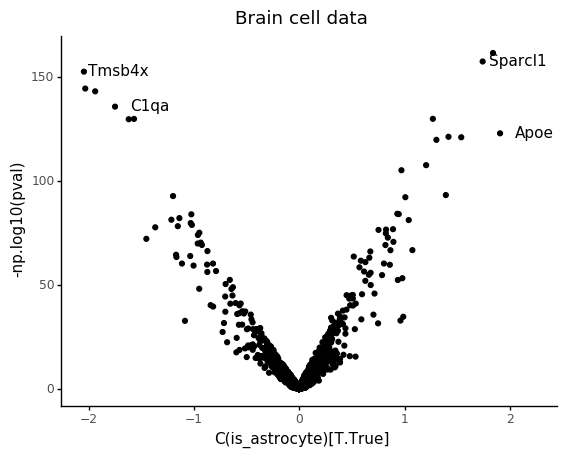

<ggplot: (-9223372036499795445)>

In [184]:
img = \
p.qplot('C(is_astrocyte)[T.True]', '-np.log10(pval)', lr_results) \
    + p.annotate('text',
                 x=examples['C(is_astrocyte)[T.True]'] + 0.33,
                 y=-np.log10(examples['pval']),
                 label=examples.index) \
    + p.labs(title='Brain cell data')
    
img.save('4.png', verbose=False)
img

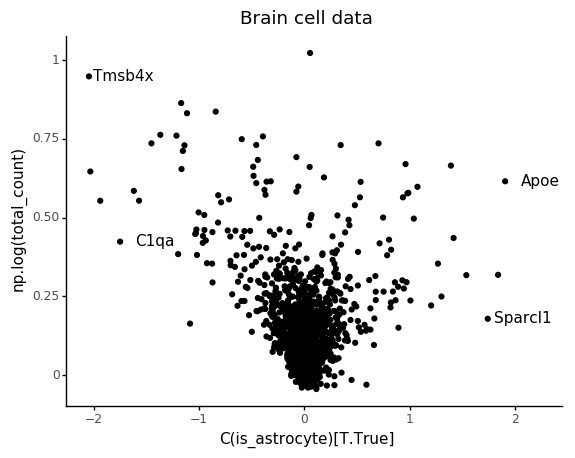

<ggplot: (369714166)>

In [185]:
img = \
p.qplot('C(is_astrocyte)[T.True]', 'np.log(total_count)', lr_results) \
    + p.annotate('text',
                 x=examples['C(is_astrocyte)[T.True]'] + 0.33,
                 y=examples['np.log(total_count)'],
                 label=examples.index) \
    + p.labs(title='Brain cell data')

img.save('5.png', verbose=False)
img

In [179]:
print(lr_results.sort_values('C(is_astrocyte)[T.True]').head())

        Intercept  C(is_astrocyte)[T.True]  np.log(total_count)  \
Tmsb4x  -3.680027                -2.044908             0.948016   
Hexb    -2.165802                -2.032087             0.646263   
Ctss    -1.665139                -1.937761             0.553429   
C1qa    -0.995722                -1.749257             0.423667   
C1qc    -2.215866                -1.619052             0.584999   

                 pval           qval  
Tmsb4x  2.742131e-153  1.472524e-150  
Hexb    3.671724e-145  1.971716e-142  
Ctss    8.167943e-144  4.386185e-141  
C1qa    1.826933e-136  9.810631e-134  
C1qc    2.119271e-130  1.138049e-127  


In [181]:
print(lr_results.sort_values('C(is_astrocyte)[T.True]').tail())

         Intercept  C(is_astrocyte)[T.True]  np.log(total_count)  \
Aldoc    -2.687079                 1.417820             0.435424   
Clu      -1.888573                 1.539004             0.317413   
Sparcl1  -1.008002                 1.742278             0.179123   
Atp1a2   -1.925596                 1.840452             0.318532   
Apoe     -3.426031                 1.907639             0.615229   

                  pval           qval  
Aldoc    5.683797e-122  3.052199e-119  
Clu      9.768731e-122  5.245808e-119  
Sparcl1  3.548817e-158  1.905715e-155  
Atp1a2   3.058918e-162  1.642639e-159  
Apoe     1.250247e-123  6.713825e-121  


Also in this case we can see that the count depth weights are deflated for lowly abundant genes.

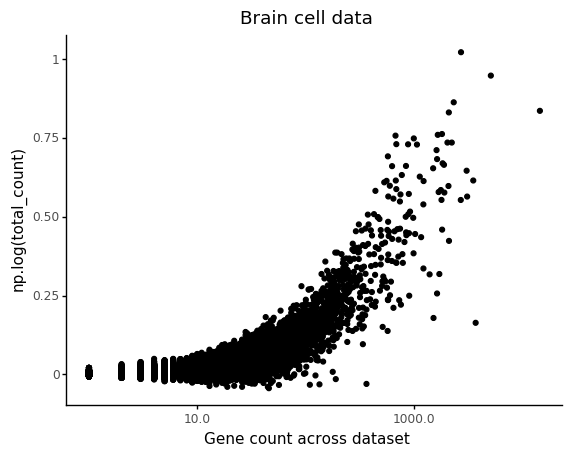

<ggplot: (-9223372036478748363)>

In [186]:
img = \
p.qplot(sub_counts.sum(0).clip_lower(1), lr_results['np.log(total_count)'],
        log='x') \
    + p.labs(x='Gene count across dataset', y='np.log(total_count)', 
             title='Brain cell data')
    
img.save('6.png', verbose=False)
img

In [44]:
xx = np.linspace(np.log(sub_samples.total_count.min()),
                 np.log(sub_samples.total_count.max()))

def linres(gene):
    yy = \
    lr_results.loc[gene, 'np.log(total_count)'] * xx \
        + lr_results.loc[gene, 'Intercept']

    yy1 = np.exp(yy)
    yy2 = np.exp(yy + lr_results.loc[gene, 'C(is_astrocyte)[T.True]'])
    
    return yy1, yy2

Similar to above, we can look at the relation between count depth and observed counts for a few genes, but we can also make sure to plot the stratifiction into the two cell types and how the regression models are predicting the counts.

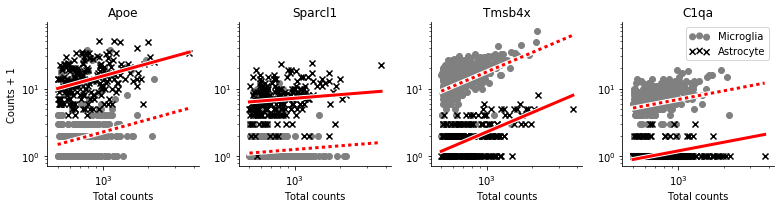

In [187]:
figsize(11, 3)


ax = plt.gca()
for i, gene in enumerate(['Apoe', 'Sparcl1', 'Tmsb4x', 'C1qa']):
    sub_samples['gene'] = counts[gene]
    
    plt.subplot(1, 4, i + 1, sharey=ax)
    if i == 0:
        plt.ylabel('Counts + 1')
    
    plt.loglog()

    plt.scatter(sub_samples.loc[~sub_samples.is_astrocyte]['total_count'],
                sub_samples.loc[~sub_samples.is_astrocyte]['gene'] + 1,
                c='grey', marker='o', label='Microglia')
    
    
    plt.scatter(sub_samples.loc[sub_samples.is_astrocyte]['total_count'],
                sub_samples.loc[sub_samples.is_astrocyte]['gene'] + 1,
                c='k', marker='x', label='Astrocyte')

    yy1, yy2 = linres(gene)

    plt.plot(np.exp(xx), yy1, c='w', lw=5)
    plt.plot(np.exp(xx), yy1, c='r', lw=3, ls=':')

    plt.plot(np.exp(xx), yy2, c='w', lw=5)
    plt.plot(np.exp(xx), yy2, c='r', lw=3)
    
    plt.title(gene)
    plt.xlabel('Total counts')

plt.legend(scatterpoints=3);
    
plt.tight_layout()
plt.savefig('7.png', bbox_inches='tight')

Again we can see the overall abundance is related to the slope of the lines. Another thing which seem to pop out in these plots is an interaction between cell type and slope. For example looking at C1qa the slope for the microglia seem underestimated. This makes sense, if this is an effect of count noise at low abundances.

My takeaway from this is that OLS regression might be OK if counts are large, but at lower levels model parameters are not estimated correctly due to the count nature of the data.

Notebooks of the analysis in this post are available here.